In [ ]:
import pandas as pd
import numpy as np
from scipy.fftpack import fft


df = pd.read_csv('/content/output_elesense.csv')
adc_values = df['Data'].values

sampling_rate = 250
window_size = 100

def create_windows(data, window_size):
    windows = [data[i:i + window_size] for i in range(0, len(data), window_size)]
    return windows


def spectral_flatness(fft_values):
    geometric_mean = np.exp(np.mean(np.log(fft_values + 1e-10))) 
    arithmetic_mean = np.mean(fft_values)
    return geometric_mean / arithmetic_mean


def extract_frequency_domain_features(signal, sampling_rate):
    N = len(signal)
    freqs = np.fft.fftfreq(N, 1/sampling_rate)
    fft_values = np.abs(fft(signal))

    peak_freq = freqs[np.argmax(fft_values)]

    spectral_spread = np.sqrt(np.sum(((freqs - peak_freq) ** 2) * fft_values) / np.sum(fft_values))

    fft_area = np.sum(fft_values)

    spec_flatness = spectral_flatness(fft_values)

    return [peak_freq, spectral_spread, fft_area, spec_flatness]

windows = create_windows(adc_values, window_size)
frequency_features = [extract_frequency_domain_features(window, sampling_rate) for window in windows]


columns = ['Peak_Frequency', 'Spectral_Spread', 'FFT_Area', 'Spectral_Flatness']

features_df = pd.DataFrame(frequency_features, columns=columns)
features_csv_path = 'extracted_frequency_features_selected.csv'
features_df.to_csv(features_csv_path, index=False)

print(f"Features saved to: {features_csv_path}")


Features saved to: extracted_frequency_features_selected.csv


In [2]:
import pandas as pd

df = pd.read_csv('/content/extracted_frequency_features_selected.csv')

def label_peak_frequency(row):
    if 15 <= row['Peak_Frequency'] <= 60:
        return 1
    else:
        return 0

df['Label'] = df.apply(label_peak_frequency, axis=1)

output_file_path = 'labeled_features.csv'
df.to_csv(output_file_path, index=False)

print(f"Updated CSV file saved as: {output_file_path}")


Updated CSV file saved as: labeled_features.csv


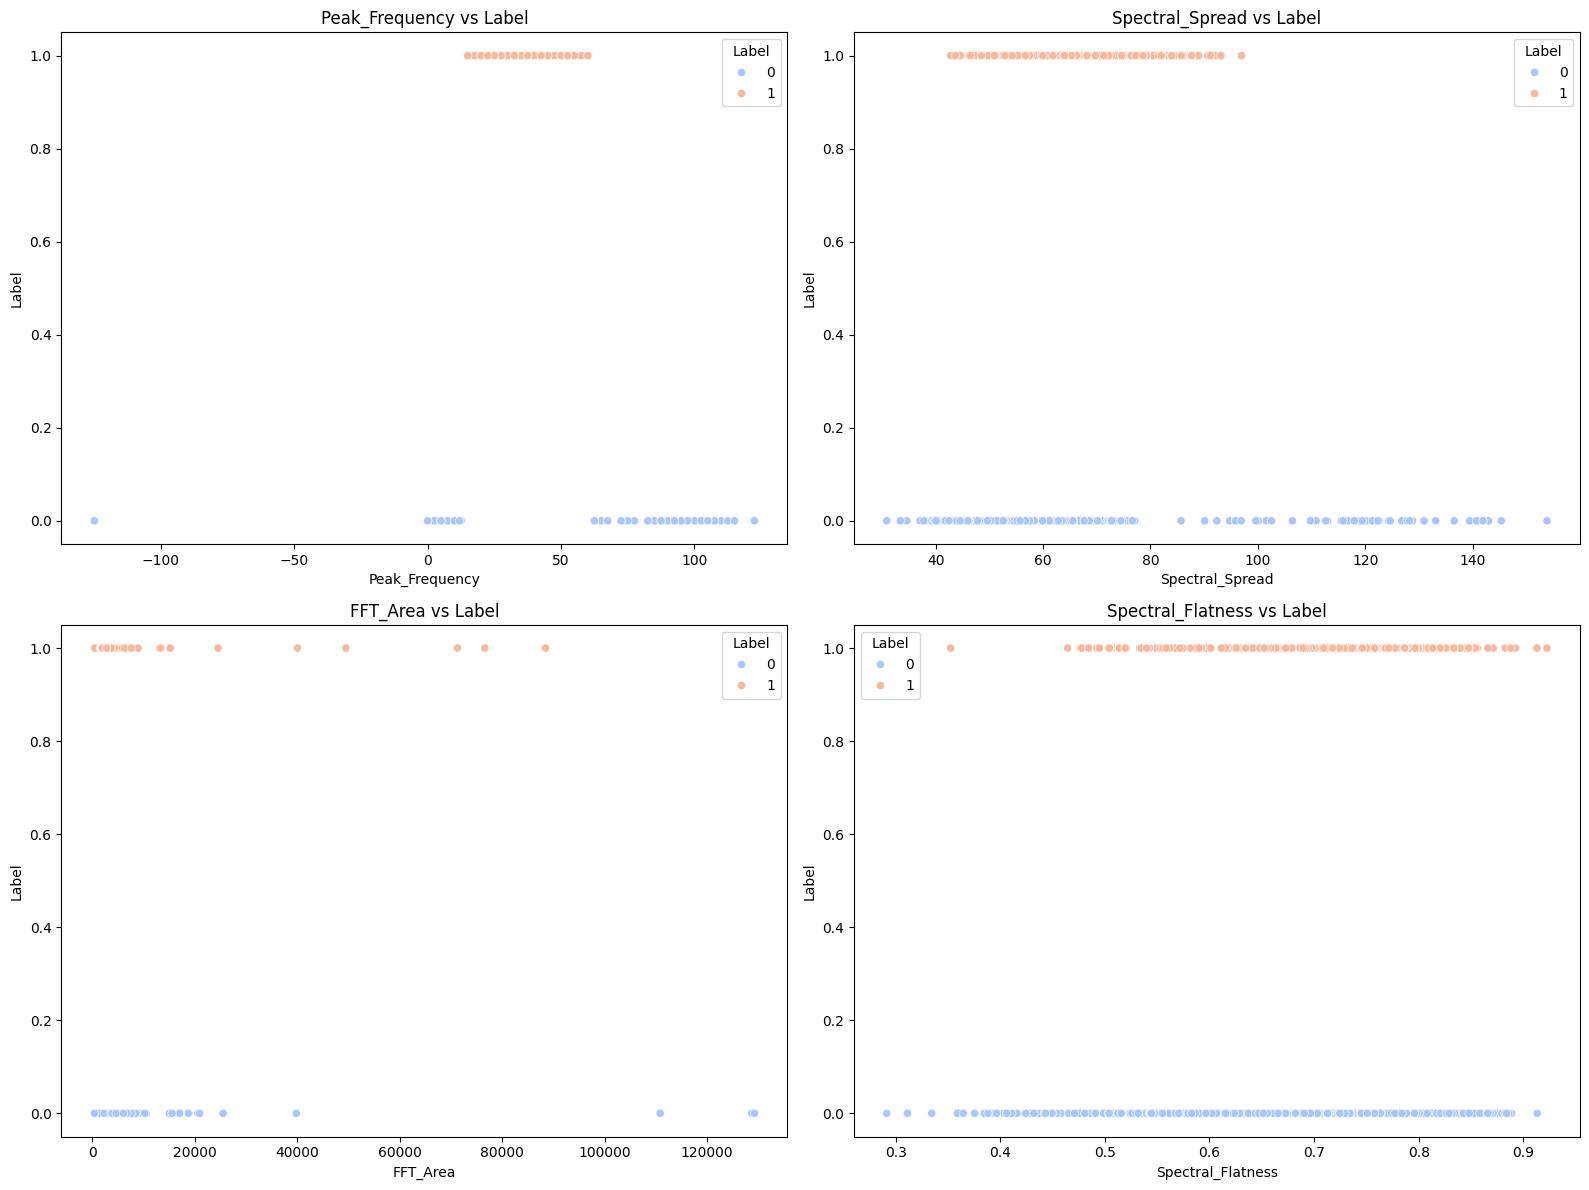

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('/content/labeled_features.csv')

# List of features to plot
features = ['Peak_Frequency', 'Spectral_Spread', 'FFT_Area', 'Spectral_Flatness']

# Set up the figure size
plt.figure(figsize=(16, 12))

# Create scatter plots for each feature
for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(x=df[feature], y=df['Label'], hue=df['Label'], palette='coolwarm')
    plt.title(f'{feature} vs Label')
    plt.xlabel(feature)
    plt.ylabel('Label')

plt.tight_layout()
plt.show()


Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4963 - loss: 0.6970 - val_accuracy: 0.5066 - val_loss: 0.6782
Epoch 2/40
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5335 - loss: 0.6759 - val_accuracy: 0.5399 - val_loss: 0.6661
Epoch 3/40
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5515 - loss: 0.6691 - val_accuracy: 0.5997 - val_loss: 0.6548
Epoch 4/40
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5614 - loss: 0.6657 - val_accuracy: 0.6346 - val_loss: 0.6419
Epoch 5/40
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6162 - loss: 0.6485 - val_accuracy: 0.6628 - val_loss: 0.6300
Epoch 6/40
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6579 - loss: 0.6266 - val_accuracy: 0.7143 - val_loss: 0.6177
Epoch 7/40
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6362 - loss: 0.6308 - val_accuracy: 0.7542 - val_loss: 0.6068
Epoch 8/40
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6998 - loss: 0.6253 - val_accuracy: 0.7791 - val_

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Classification Accuracy: 95.35%

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       305
           1       0.95      0.95      0.95       297

    accuracy                           0.95       602
   macro avg       0.95      0.95      0.95       602
weighted avg       0.95      0.95      0.95       602



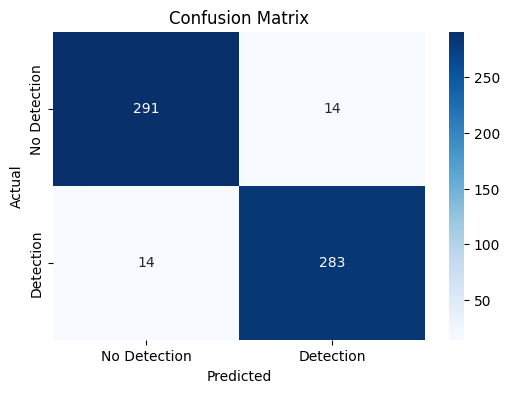

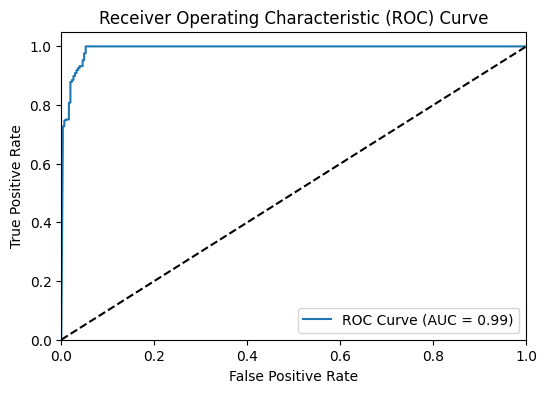

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split  # Import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import seaborn as sns
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, roc_auc_score

# Load data
df = pd.read_csv('/content/labeled_features.csv')
X = df.drop('Label', axis=1).values
y = df['Label'].values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Balance the dataset with SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_scaled, y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Build model
model = Sequential()
model.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, epochs=40, batch_size=4, validation_data=(X_test, y_test))

# Save model and scaler
model.save('model.h5')
joblib.dump(scaler, 'scaler.pkl')

# Make predictions and evaluate
y_pred_prob = model.predict(X_test)
threshold = 0.55
y_pred_new = (y_pred_prob >= threshold).astype(int)

accuracy = accuracy_score(y_test, y_pred_new)
print(f"Classification Accuracy: {accuracy * 100:.2f}%")

report = classification_report(y_test, y_pred_new)
print("\nClassification Report:\n", report)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_new)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Detection", "Detection"], yticklabels=["No Detection", "Detection"])
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model("model.h5")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", "wb") as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpsvqv7zd9'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 4), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139914574109104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139914574105056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139914574258496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139914574260784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139914574266064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139914572252432: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [ ]:
import numpy as np
import pandas as pd
import joblib
import tflite_runtime.interpreter as tflite
from sklearn.metrics import classification_report, accuracy_score

scaler = joblib.load("scaler.pkl")

interpreter = tflite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def classify(features):

    input_data = np.array(features, dtype=np.float32).reshape(1, -1)
    scaled_data = scaler.transform(input_data)


    interpreter.set_tensor(input_details[0]['index'], scaled_data.astype(np.float32))

    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])
    prediction = output_data[0][0]
    return prediction

def manual_input_and_classify():
    print("Please enter the following features:")
    peak_freq = float(input("Peak Frequency: "))
    spectral_spread = float(input("Spectral Spread: "))
    spectral_entropy = float(input("Spectral Entropy: "))
    spectral_centroid = float(input("Spectral Centroid: "))

    features = [peak_freq, spectral_spread, spectral_entropy, spectral_centroid]

    prediction = classify(features)
    if prediction > 0.5:
        print(f"Elephant detected with confidence {prediction:.2f}")
    else:
        print(f"No elephant detected, confidence {prediction:.2f}")

def evaluate_model(csv_file_path):

    df = pd.read_csv(csv_file_path)

    X = df[['Peak_Frequency', 'Spectral_Spread', 'Spectral_Entropy', 'Spectral_Centroid']].values
    y_true = df['Label'].values

    y_pred = []
    for features in X:
        prediction = classify(features)

        y_pred.append(1 if prediction > 0.5 else 0)

    accuracy = accuracy_score(y_true, y_pred)
    print(f"Classification Accuracy: {accuracy * 100:.2f}%")
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

if __name__ == "__main__":
 
    manual_input_and_classify()

    csv_file_path = '/content/labeled_features.csv' 
    evaluate_model(csv_file_path)


Please enter the following features:
Peak Frequency: 47.5
Spectral Spread: 81
Spectral Entropy: 2333
Spectral Centroid: 0.82
Elephant detected with confidence 0.65


KeyError: "['Spectral_Entropy', 'Spectral_Centroid'] not in index"

In [7]:
pip install tflite-runtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 20.5 MB/s eta 0:00:00
